## Facial keypoints detection

In this task you will create facial keypoint detector based on CNN regressor.


![title](example.png)

### Load and preprocess data

Script `get_data.py` unpacks data — images and labelled points. 6000 images are located in `images` folder and keypoint coordinates are in `gt.csv` file. Run the cell below to unpack data.

Now you have to read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. We will make following preprocessing:
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [1]:
import numpy as np
from os.path import join
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize
import pandas as pd

In [2]:
def load_imgs_and_keypoints(dirname='data'):
    gt = pd.read_csv('data/gt.csv')
    imgs = []
    points = []
    for index, row in gt.iterrows():
        img = gray2rgb(imread('data/images/' + row["filename"]))
        img_points = []
        for i in range(1, 15):
            img_points.append( row["x" + str(i)] / img.shape[1] - .5 )
            img_points.append( row["y" + str(i)] / img.shape[0] - .5 )
        points.append( img_points )
        img = resize(img, (100, 100))
        imgs.append(img)
        #if index > 30:
        #    break
        
    return np.array(imgs), np.array(points)

In [3]:
imgs, points = load_imgs_and_keypoints()
print(imgs.shape)
print(points.shape)
print(points[0])

c:\program files\python35\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(6000, 100, 100, 3)
(6000, 28)
[-0.30534351 -0.30534351 -0.01526718 -0.27099237  0.14503817 -0.2519084
  0.27480916 -0.30152672 -0.24045802 -0.20610687 -0.17557252 -0.21374046
 -0.08015267 -0.1870229   0.11068702 -0.16793893  0.15267176 -0.19847328
  0.23664122 -0.17938931  0.09541985  0.04961832 -0.14885496  0.16412214
  0.03435115  0.1870229   0.14122137  0.18320611]


c:\program files\python35\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
c:\program files\python35\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


array([-0.30534351, -0.30534351, -0.01526718, -0.27099237,  0.14503817,
       -0.2519084 ,  0.27480916, -0.30152672, -0.24045802, -0.20610687,
       -0.17557252, -0.21374046, -0.08015267, -0.1870229 ,  0.11068702,
       -0.16793893,  0.15267176, -0.19847328,  0.23664122, -0.17938931,
        0.09541985,  0.04961832, -0.14885496,  0.16412214,  0.03435115,
        0.1870229 ,  0.14122137,  0.18320611])

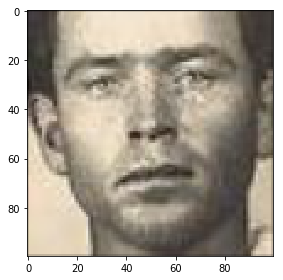

In [4]:
# Example of output
%matplotlib inline
from skimage.io import imshow
imshow(imgs[1000])
points[0]

### Visualize data

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

In [5]:
import matplotlib.pyplot as plt
# Circle may be useful for drawing points on face
# See matplotlib documentation for more info
#from matplotlib.patches import Circle
#plt.Circle((0, 0), 0.2, color='r')

def visualize_points(img, points):
    # Write here function which obtains image and normalized
    # coordinates and visualizes points on image
    imshow(img)
    for i in range(14):
        plt.scatter( (points[2*i] + .5 )*100, (points[2*i + 1] + .5 )*100, s=100, c='r')
    

c:\program files\python35\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
c:\program files\python35\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


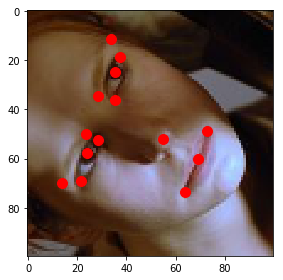

In [6]:
visualize_points(imgs[2], points[2])

### Train/val split

Run the following code to obtain train/validation split for training neural network.

In [7]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1)

### Simple data augmentation

For better training we will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face). VIsualize an example of original and flipped image.

In [8]:
def flip_img(img, points):
    f_points = np.zeros(points.shape)
    f_points[:] = points
    for i in range(14):
        f_points[2*i] = -1 * f_points[2*i] 
    f_img = np.flip(img, axis=1)
    return f_img, f_points

c:\program files\python35\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
c:\program files\python35\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


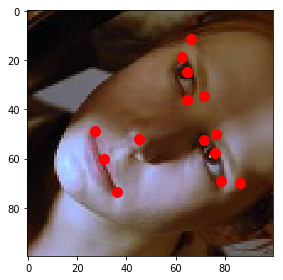

In [9]:
f_img, f_points = flip_img(imgs[2], points[2])
visualize_points(f_img, f_points)

Time to augment our training sample. Apply flip to every image in training sample. As a result you should obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

In [10]:
aug_imgs_train, aug_points_train = [], []

for i in range(len(imgs_train)):
    f_img, f_points = flip_img(imgs_train[i], points_train[i])
    aug_imgs_train.append(f_img)
    aug_points_train.append(f_points)
    
aug_imgs_train, aug_points_train = np.array(aug_imgs_train), np.array(aug_points_train)

c:\program files\python35\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
c:\program files\python35\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


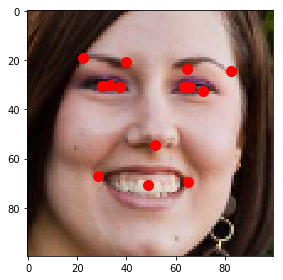

In [11]:
visualize_points(aug_imgs_train[2], aug_points_train[2])

c:\program files\python35\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
c:\program files\python35\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


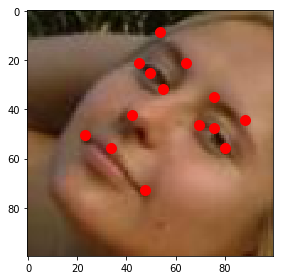

In [12]:
visualize_points(aug_imgs_train[3], aug_points_train[3])

In [13]:
print(imgs_train.shape)
print(points_train.shape)
imgs_train = np.concatenate((imgs_train, aug_imgs_train), axis=0)
points_train = np.concatenate((points_train, aug_points_train), axis=0)
print(imgs_train.shape)
print(points_train.shape)

(5400, 100, 100, 3)
(5400, 28)
(10800, 100, 100, 3)
(10800, 28)


In [14]:
import keras

Using TensorFlow backend.


In [15]:
def append_history(history, h_partition):
    for key in h_partition:
        history[key] = h_partition[key] if key not in history else history[key] + h_partition[key]

In [16]:
def clean_obsolete_history(history, n_last_iter):
    for key in history:
        history[key] = history[key][-n_last_iter:]

In [17]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (13, 5)

def plot_training_history(history, ylog=False):
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    if ylog:
        plt.yscale('log')
    plt.grid(True)
    plt.show()

### Network architecture and training

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point. The precise architecture is up to you. We recommend to add 2-3 (`Conv2D` + `MaxPooling2D`) pairs, then `Flatten` and 2-3 `Dense` layers. Don't forget about ReLU activations. We also recommend to add `Dropout` to every `Dense` layer (with p from 0.2 to 0.5) to prevent overfitting.


In [18]:
def conv_layer(layer, filters, kernel, activation):
    layer = keras.layers.Conv2D(filters=filters,
                                kernel_size=(kernel, kernel),
                                strides=(1,1),
                                activation=None,
                                padding="same", # "same", "valid"
                                kernel_initializer='he_normal' #'TruncatedNormal' #'he_normal' # 'he_uniform'
                                ,use_bias=True
                               )(layer)
    layer = keras.layers.BatchNormalization(axis=-1)(layer)
    layer = keras.layers.Activation(activation)(layer)
    return layer

def conv_block(layer, n_conv_layers, filters, kernel, activation, maxpool=True):
    for _ in range(n_conv_layers):
        layer = conv_layer(layer, filters, kernel, activation)
        
    if maxpool:
        layer = keras.layers.MaxPooling2D(pool_size=2)(layer)
    else:
        layer = keras.layers.AveragePooling2D(pool_size=2)(layer)
        
    layer = keras.layers.Dropout(0.1)(layer)
    return layer

def dense(layer, n_units):
    layer = keras.layers.Dense(n_units, activation=None, use_bias=True
                               ,kernel_initializer='he_uniform' #'TruncatedNormal' #'he_normal' # 'he_uniform'
                              )(layer)
    layer = keras.layers.BatchNormalization(axis=-1)(layer)
    layer = keras.layers.Activation("selu")(layer) # selu
    layer = keras.layers.Dropout(0.5)(layer)
    return layer

In [19]:
input = keras.layers.Input(shape=(100, 100, 3))
layer = input

layer = keras.layers.Dropout(0.1)(layer)

layer = conv_block(layer, 3, 8, 3, 'selu')
layer = conv_block(layer, 2, 16, 3, 'selu')
layer = conv_block(layer, 1, 32, 3, 'selu')

layer = keras.layers.Flatten()(layer)

layer = dense(layer, 256)
layer = dense(layer, 128)

layer = keras.layers.Dense(28, activation=None,
                           use_bias=True
                          )(layer)
model = keras.models.Model(inputs=input, outputs=layer)

Time to train! Since we are training a regressor, make sure that you use mean squared error (mse) as loss. Feel free to experiment with optimization method (SGD, Adam, etc.) and its' parameters.

In [20]:
# ModelCheckpoint can be used for saving model during training.
# Saved models are useful for finetuning your model 
# See keras documentation for more info

#optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.5, decay=0.001, nesterov=False)
#optimizer = keras.optimizers.Adam(lr=0.01) #, beta_1=0.9, beta_2=0.99, amsgrad=False
#optimizer = keras.optimizers.Adadelta(lr=0.01, rho=0.97)
optimizer = keras.optimizers.RMSprop(lr=0.001) # best: lr=0.01, rho=0.9

model.compile(loss = "mean_squared_error",
              optimizer = optimizer,
              metrics = ["mse"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 8)       224       
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 100, 8)       32        
_________________________________________________________________
activation_1 (Activation)    (None, 100, 100, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 8)       584       
_________________________________________________________________
batch_normalization_2 (Batch (None, 100, 100, 8)       32        
__________

In [21]:
callbacks = []
callbacks.append(keras.callbacks.EarlyStopping( monitor='val_loss',
                                                min_delta=0,
                                                patience=2,
                                                verbose=1,
                                                mode='auto'))
callbacks = []
history = {}

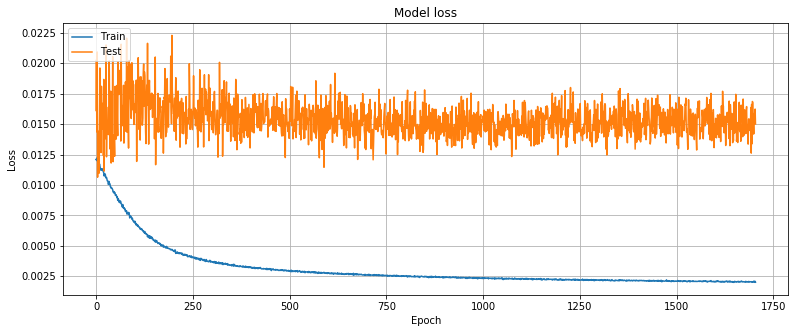

Train on 10800 samples, validate on 600 samples
Epoch 1/5
10800/10800 [==============================] - 8s 751us/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0164 - val_mean_squared_error: 0.0164
Epoch 2/5
10800/10800 [==============================] - 8s 745us/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0155 - val_mean_squared_error: 0.0155
Epoch 3/5
10800/10800 [==============================] - 8s 744us/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0145 - val_mean_squared_error: 0.0145
Epoch 4/5
10800/10800 [==============================] - 8s 741us/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0152 - val_mean_squared_error: 0.0152
Epoch 5/5
 9216/10800 [========================>.....] - ETA: 1s - loss: 0.0021 - mean_squared_error: 0.0021

In [ ]:
from IPython.display import clear_output

for _ in range(2000):
    h_partition = model.fit(imgs_train, points_train,
                            batch_size=1024,
                            epochs=5,
                            verbose=1,
                            validation_data=(imgs_val, points_val),
                            callbacks=callbacks)
    append_history(history, h_partition.history)
    clear_output(wait=True)
    plot_training_history(history)
    #plot_training_history(history, ylog=True)

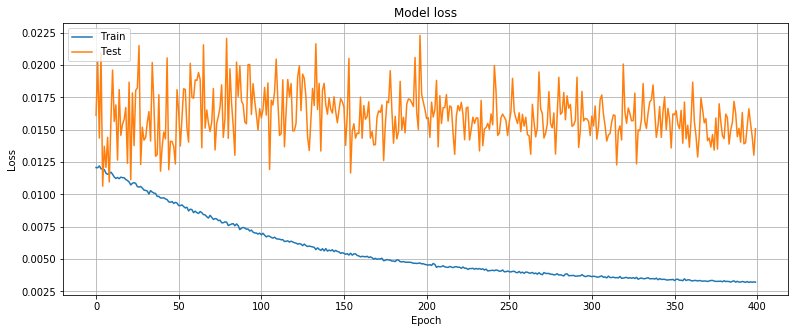

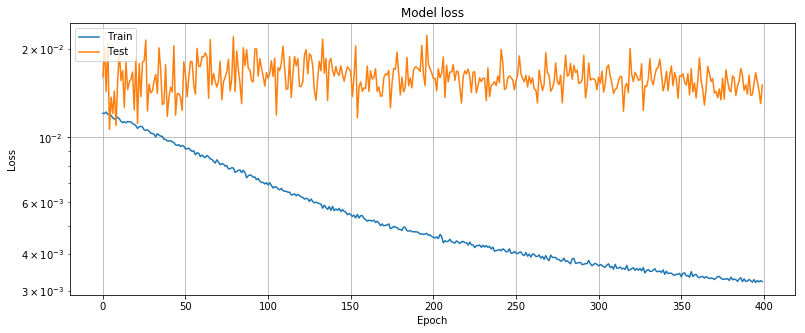

In [25]:
plot_training_history(history)
plot_training_history(history, ylog=True)
#plot_training_history(h_partition.history)
#plot_training_history(h_partition.history, ylog=True)

In [24]:
#clean_obsolete_history(history, 1500)

### Visualize results

Now visualize neural network results on several images from validation sample. Make sure that your network outputs different points for images (i.e. it doesn't output some constant).

In [26]:
def predict(img):
    points_pred = model.predict(img.reshape((1, 100, 100, 3)))[0]
    visualize_points(img, points_pred)

c:\program files\python35\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
c:\program files\python35\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


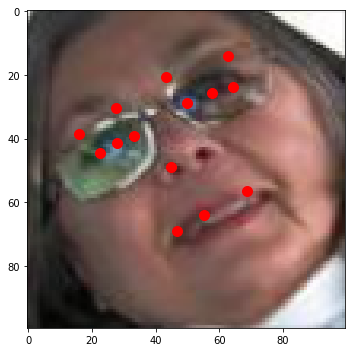

In [27]:
predict(imgs_val[1])

In [ ]:
visualize_points(imgs_val[9], points_val[9])